In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from astropy.timeseries import LombScargle
from astropy import units as u
from astropy import constants as const
from scipy.optimize import bisect

kelt = '/home/rowan.90/polarisproject2022/kelt_clipped.csv'
stella = '/home/rowan.90/polarisproject2022/stella_rv.dat'
gaia = pd.read_csv('/home/rowan.90/EBs/polaris_gaia.csv')

def plotparams(ax):
    '''
    Basic plot params 

    :param ax: axes to modify

    :type ax: matplotlib axes object

    :returns: modified matplotlib axes object
    '''
    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in', which='both', labelsize=15)
    ax.tick_params('both', length=8, width=1.8, which='major')
    ax.tick_params('both', length=4, width=1, which='minor')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax

In [2]:
df_kelt = pd.read_csv(kelt)
df_kelt

,set,hjd,mag
0,0,2.456303e+06,10.76544
1,0,2.456303e+06,10.75570
2,0,2.456303e+06,10.76870
3,0,2.456303e+06,10.77059
4,0,2.456303e+06,10.78203
...,...,...,...
1349,0,2.456243e+06,10.77738
1350,0,2.456243e+06,10.78720
1351,0,2.456243e+06,10.78879
1352,0,2.456243e+06,10.78595


Text(0, 0.5, 'Magnitude')

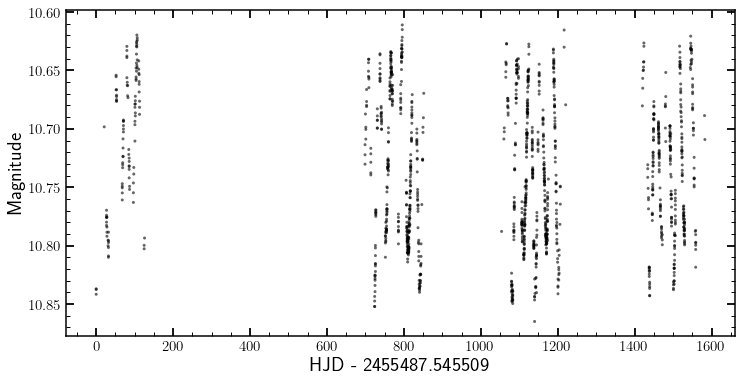

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.scatter(df_kelt.hjd-df_kelt.hjd.min(), df_kelt.mag, 
           marker='.', color='black', edgecolor='none', alpha=0.6)
ax.invert_yaxis()
ax.set_xlabel(f'HJD - {df_kelt.hjd.min()}', fontsize=20)
ax.set_ylabel('Magnitude', fontsize=20)

Text(0.95, 0.95, '$P=30.03$')

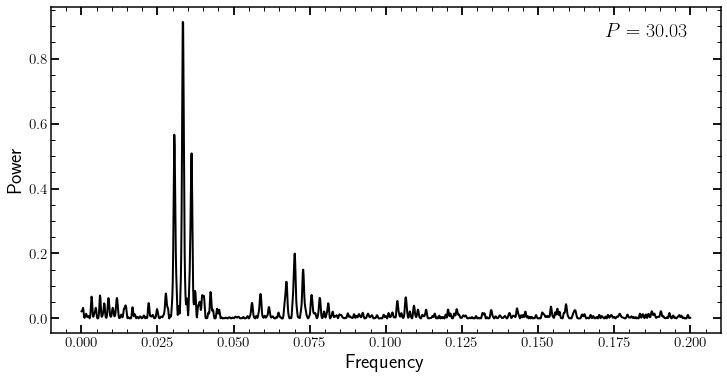

In [4]:
frequency, power = LombScargle(df_kelt.hjd, df_kelt.mag).autopower(maximum_frequency=0.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.plot(frequency, power, color='black', lw=2)
ax.set_xlabel('Frequency', fontsize=20)
ax.set_ylabel('Power', fontsize=20)

#ax.axvline(frequency[np.argmax(power)])

ax.text(.95, .95, r'$P={}$'.format(round(1/frequency[np.argmax(power)], 2)), ha='right', va='top',
        fontsize=20, transform=ax.transAxes)

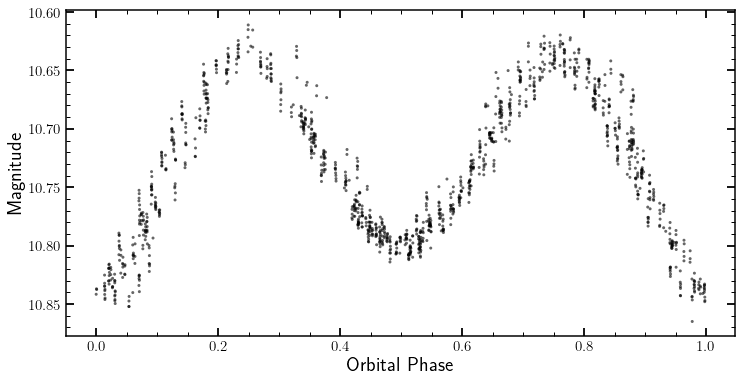

In [5]:
period = 1/frequency[np.argmax(power)] * 2
df_kelt['phase'] = ((df_kelt.hjd - df_kelt.hjd.min()) % period)/period
#df_kelt['phase'] = ((df_kelt.hjd-df_kelt.hjd.min())/period)%period

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.scatter(df_kelt.phase, df_kelt.mag, marker='.', color='black', edgecolor='none', alpha=0.6)
ax.set_xlabel('Orbital Phase', fontsize=20)
ax.set_ylabel('Magnitude', fontsize=20)
ax.invert_yaxis()

In [6]:
df_stella = pd.read_table(stella, delim_whitespace=True)
df_stella['phase'] = ((df_stella.BJD - df_kelt.hjd.min()) % period)/period
df_stella['phi'] = df_stella.phase * 2*np.pi
df_stella

,BJD,RV,Sigma,phase,phi
0,2.454066e+06,-63.359,0.243,0.326665,2.052495
1,2.454067e+06,-63.407,0.199,0.344497,2.164536
2,2.454074e+06,-47.100,0.667,0.460690,2.894601
3,2.454074e+06,-43.862,0.305,0.461248,2.898109
4,2.454093e+06,61.584,0.199,0.775407,4.872028
...,...,...,...,...,...
82,2.455241e+06,58.147,0.139,0.887230,5.574628
83,2.455266e+06,-62.580,0.148,0.319207,2.005637
84,2.455285e+06,36.069,0.148,0.634714,3.988023
85,2.455290e+06,58.852,0.114,0.717788,4.509995


Text(0, 0.5, 'RV (km/s)')

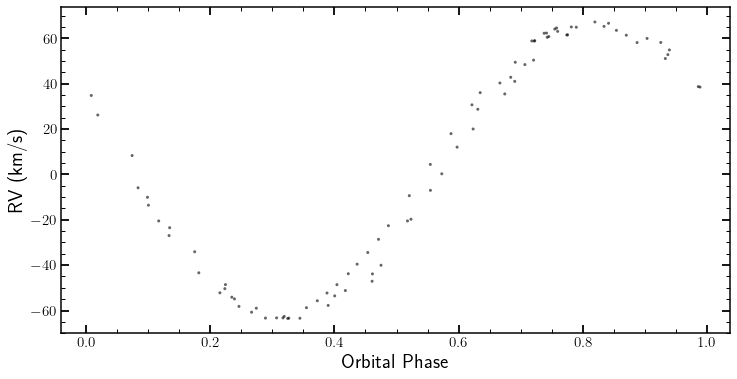

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.scatter(df_stella.phase, df_stella.RV, marker='.', color='black', edgecolor='none', alpha=0.6)
ax.set_xlabel('Orbital Phase', fontsize=20)
ax.set_ylabel('RV (km/s)', fontsize=20)


Text(0.95, 0.05, '$P=60.07$ d\n$K=64.97$ km/s')

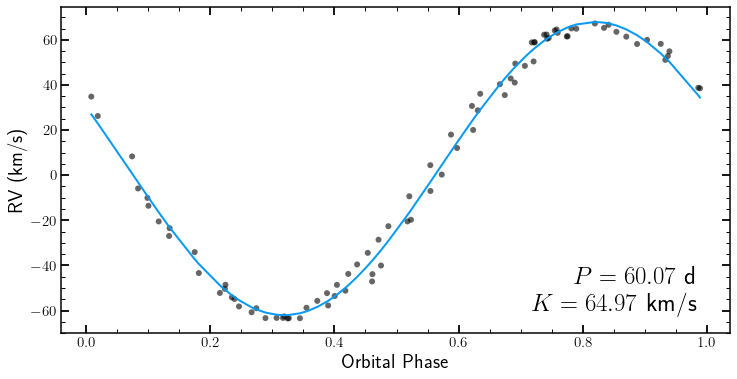

In [8]:
#Example of using linear regression to fit sine of known frequency
cos_term = np.cos(df_stella.phi)
sin_term = np.sin(df_stella.phi)
a0 = np.ones(len(sin_term))
A_matrix = np.column_stack((a0, cos_term, sin_term))
xhat, residuals, rank, s = np.linalg.lstsq(
        A_matrix, df_stella.RV, rcond=None)
amp = np.sqrt(xhat[1]**2+xhat[2]**2)
delta = np.arctan(-xhat[2]/xhat[1])

model_vals = amp*np.cos(df_stella.phi+delta)+xhat[0]
df_stella['model'] = model_vals
df_stella = df_stella.sort_values(by='phase', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.scatter(df_stella.phase, df_stella.RV, marker='o', color='black', edgecolor='none', alpha=0.6)
ax.set_xlabel('Orbital Phase', fontsize=20)
ax.set_ylabel('RV (km/s)', fontsize=20)
ax.plot(df_stella.phase, df_stella.model, color='xkcd:azure', lw=2)
ax.text(.95, .05, r'$P={}$ d'.format(round(period,2))+'\n'+r'$K={}$ km/s'.format(round(amp,2)),
        ha='right', va='bottom', fontsize=25, transform=ax.transAxes)

In [9]:
#Compute the binary mass function
f = (period*u.day*np.power(amp*u.km/u.s, 3)/(2*np.pi*const.G)).to('Msun')
print(f)

1.7066779755601826 solMass


Next we want to solve for $M_{\rm{BH}}$:

$$
\frac{M_*^3 \sin^3 i}{(M_{\rm{BH}}+M_*)^2} = f = \frac{P K^3}{2\pi G}
$$

In [10]:
Mstar = 1.0

def cubic_func(M):
    
    return M**3 - f.value*M**2 - 2*f.value*M*Mstar - f.value*Mstar**2

bisect(cubic_func, 0.1, 10)

3.0227080747077597

Text(0, 0.5, '$M_G$')

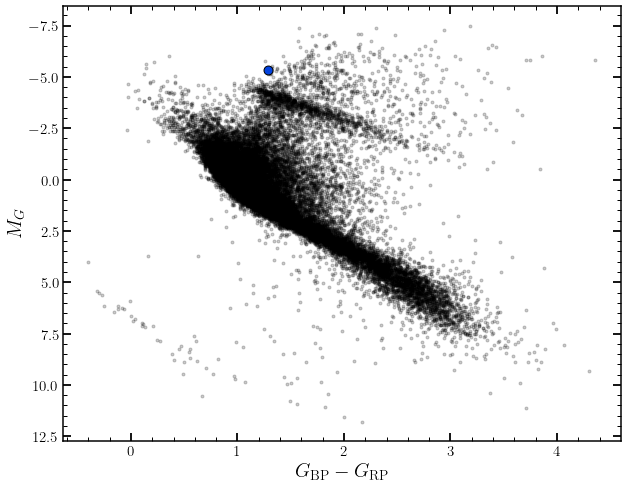

In [11]:
##Now doing the gaia CMD
source_id_unicorn = 3104145904761393408
idx_unicorn = np.where(gaia.source_id == source_id_unicorn)[0][0]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plotparams(ax)
gaia['absolute_g'] = gaia.phot_g_mean_mag-5*np.log10(gaia.rpgeo)
ax.scatter(gaia.bp_rp, gaia.absolute_g, color='black', marker='.', alpha=0.2, rasterized=True)
ax.scatter(gaia.bp_rp.iloc[idx_unicorn], gaia.absolute_g.iloc[idx_unicorn], 
           color='xkcd:blue', marker='o', edgecolor='black', s=80)
ax.invert_yaxis()
ax.set_xlabel(r'$G_{\rm{BP}}-G_{\rm{RP}}$', fontsize=20)
ax.set_ylabel(r'$M_G$',fontsize=20)
